In [1]:
import requests
import time
import numpy as np
from datetime import datetime
import random 

import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import shap
import seaborn as sns
from tqdm import tqdm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pd.options.display.float_format = '{:_.2f}'.format
pd.set_option('display.max_columns', 50)

In [3]:
API_KEY = '84f6d11d1973b0c18be917aa'

In [4]:
rates = requests.get(f'https://v6.exchangerate-api.com/v6/{API_KEY}/latest/RUB').json()['conversion_rates']
rate = rates.pop('RUB')
rates.update({'RUR': rate})

In [5]:
def in_(sub_strs, str_):
  for sub_str in sub_strs:
    if sub_str.lower() in str_.lower():
      return True
  return False

def estimate_salary(el):
  if el['salary'] is not None:
    if el['salary_from'] is None:
      salary_amount = (el['salary_to'] * 0.66 + el['salary_to']) / 2
    elif el['salary_to'] is None:
      salary_amount = (el['salary_from'] + el['salary_from'] * 1.5) / 2
    else:
      salary_amount = (el['salary_from'] + el['salary_to']) / 2
    
    salary_amount /= rates[el['currency']]
    
  else:
    salary_amount = None

  return salary_amount

In [6]:
jobs = []
for i in range(20):
  items = requests.get('https://api.hh.ru/vacancies', params={'page': i, 'per_page': 100, 'text': 'Data Scientist'}).json()['items']
  jobs.extend(items)
  if len(items) < 100:
    break
jobs = [job for job in jobs if in_(['data',
                                    'ml',
                                    'machine learning',
                                    'nlp',
                                    'cv',
                                    'computer vision',
                                    'дата',
                                    'данных',
                                    'компьютерное зрение',
                                    'LLM',
                                    'recsys'], job['name'])]

In [7]:
print('Количество вакансий:', len(jobs))

Количество вакансий: 509


In [8]:
jobs_ = []
for i, job in enumerate(tqdm(jobs)):
    time.sleep(1)
    resp = requests.get(f'https://api.hh.ru/vacancies/{job["id"]}').json()
    jobs_.append(resp)
df = pd.DataFrame(jobs_)

100%|██████████| 509/509 [09:44<00:00,  1.15s/it]


In [9]:
df = df.drop(['billing_type',
         'relations',
         'insider_interview',
         'contacts',
         'branded_description',
         'vacancy_constructor_template',
         'accept_handicapped',
         'accept_kids',
         'archived',
         'response_url',
         'code',
         'hidden',
         'quick_responses_allowed',
         'driver_license_types',
         'accept_incomplete_resumes',
         'created_at',
         'initial_created_at',
         'negotiations_url',
         'suitable_resumes_url',
         'apply_alternate_url',
         'alternate_url',
         'languages',
         'approved',
         'working_days',
         'test',
         'working_time_intervals',
         'working_time_modes',
         'specializations',
         'allow_messages'], axis=1)

In [10]:
df.area = df.area.apply(lambda el: el['name'])

In [11]:
df.type = df.type.apply(lambda el: el['name'])

In [12]:
df.professional_roles = df.professional_roles.apply(lambda el: el[0]['name'])

In [13]:
df.experience = df.experience.apply(lambda el: el['name'])

In [14]:
df.schedule = df.schedule.apply(lambda el: el['name'])

In [15]:
df.employment = df.employment.apply(lambda el: el['name'])

In [16]:
df.employer = df.employer.apply(lambda el: el['name'])

In [17]:
df.department = df.department.apply(lambda el: el['name'] if el is not None else None)

In [18]:
df.key_skills = df.key_skills.apply(lambda el: [skill['name'] for skill in el])

In [19]:
df['salary_from'] = df.salary.apply(lambda el: el['from'] if el is not None else None)
df['salary_to'] = df.salary.apply(lambda el: el['to'] if el is not None else None)
df['currency'] = df.salary.apply(lambda el: el['currency'] if el is not None else None)
df.replace(np.nan, None, inplace=True)
df['rur_salary_avg'] = df.apply(estimate_salary, axis=1)
df['rur_salary_from'] = df.apply(lambda el: el['salary_from'] / rates[el['currency']] if el['salary_from'] is not None else None, axis=1)
df['rur_salary_to'] = df.apply(lambda el: el['salary_to'] / rates[el['currency']] if el['salary_to'] is not None else None, axis=1)
df = df.drop(['salary'], axis=1)

In [20]:
df['grade'] = df['name']\
.apply(lambda el: 'lead' if 'lead' in el.lower()
else 'middle_plus' if ('middle' in el.lower() and 'senior' in el.lower()) or 'middle+' in el.lower()
else 'senior' if 'senior' in el.lower()
else 'middle' if 'middle' in el.lower()
else 'junior' if 'junior' in el.lower()
else 'intern' if 'intern' in el.lower() or 'стажёр' in el.lower() or 'стажер' in el.lower()
else None)

In [21]:
df['city'] = df.address.apply(lambda el: el['city'] if el is not None else None)
df['street'] = df.address.apply(lambda el: el['street'] if el is not None else None)
df['building'] = df.address.apply(lambda el: el['building'] if el is not None else None)
df['lat'] = df.address.apply(lambda el: el['lat'] if el is not None else None)
df['lng'] = df.address.apply(lambda el: el['lng'] if el is not None else None)
df['full_address'] = df.address.apply(lambda el: el['raw'] if el is not None else None)
df = df.drop('address', axis=1)

In [22]:
df['dt'] = datetime.now()

In [23]:
df = df.rename(columns={'name': 'name_',
                        'type': 'type_',
                        'professional_roles': 'professional_role',
                        'description': 'description_'})

In [24]:
df.id = df.id.astype(int)

In [25]:
key_skills = df.key_skills.tolist()
key_skills = {skill for sublist in key_skills for skill in sublist}

In [30]:
salaries = []

for i, job in enumerate(tqdm(jobs)):
  resp = requests.get(f'https://api.hh.ru/vacancies/{job["id"]}').json()
  time.sleep(1)
  
  job['key_skills'] = resp['key_skills']
  salary = job['salary']
  if salary is not None:
    if salary['from'] is None:
      salary_amount = (salary['to'] * 0.66 + salary['to']) / 2
    elif salary['to'] is None:
      salary_amount = (salary['from'] + salary['from'] * 1.5) / 2
    else:
      salary_amount = (salary['from'] + salary['to']) / 2

    if salary['currency'] in rates:
      salary_amount /= rates[salary['currency']]
      salaries.append(salary_amount)
    else:
      salaries.append(None)

  else:
    salaries.append(None)

# salaries = pd.Series(salaries)

  0%|          | 0/517 [00:00<?, ?it/s]


SSLError: HTTPSConnectionPool(host='api.hh.ru', port=443): Max retries exceeded with url: /vacancies/101926206 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] ssl/tls alert handshake failure (_ssl.c:1000)')))

<Axes: >

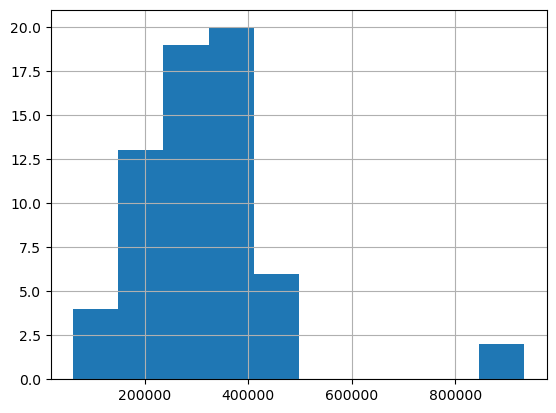

In [11]:
salaries.hist()

In [12]:
salaries.describe().rename('Сатистика по зарплатам')

count        64.00
mean    304_050.96
std     153_836.70
min      62_500.00
25%     221_250.00
50%     261_324.04
75%     375_000.00
max     932_835.82
Name: Сатистика по зарплатам, dtype: float64

In [13]:
jobs_df = pd.DataFrame(jobs)
jobs_df.key_skills = jobs_df.key_skills.apply(lambda skills: [skill['name'] for skill in skills])
jobs_df.employer = jobs_df.employer.apply(lambda el: el['name'])
jobs_df.schedule = jobs_df.schedule.apply(lambda el: el['name'])
jobs_df.area = jobs_df.area.apply(lambda el: el['name'])
jobs_df.professional_roles = jobs_df.professional_roles.apply(lambda el: el[0]['name'])
jobs_df.working_time_intervals = jobs_df.working_time_intervals.apply(lambda el: el[0]['name'] if len(el) > 0 else None)
jobs_df.employment = jobs_df.employment.apply(lambda el: el['name'])
jobs_df.department = jobs_df.department.apply(lambda el: el['name'] if el is not None else None)
jobs_df.experience = jobs_df.experience.apply(lambda el: el['name'])
jobs_df.drop(['type',
              'adv_response_url',
              'is_adv_vacancy',
              'adv_context',
              'show_logo_in_search',
              'branding',
              'accept_incomplete_resumes',
              'working_days',
              'working_time_modes',
              'response_url',
              'sort_point_distance',
              'contacts',
              'relations',
              'alternate_url',
              'url',
              'insider_interview',
              'apply_alternate_url',
              'archived'], axis=1, inplace=True)
jobs_df.set_index('id', inplace=True)

In [14]:
def flatten_series(nested_series):
    flat_list = []
    for element in nested_series:
        if isinstance(element, list):
            flat_list.extend(flatten_series(element))
        else:
            flat_list.append(element)
    return pd.Series(flat_list)

In [15]:
print('Самые важные навыки')
flatten_series(jobs_df.key_skills.tolist()).value_counts().rename('количество упоменаний навыка').head(20)

Самые важные навыки


Python                          213
SQL                             139
Machine Learning                 59
ML                               46
Spark                            40
Data Science                     40
NLP                              36
PyTorch                          34
Анализ данных                    32
Big Data                         31
Математическая статистика        28
Hadoop                           24
PostgreSQL                       22
pandas                           21
PySpark                          21
Математическое моделирование     20
Docker                           20
Airflow                          20
Data Analysis                    20
Linux                            19
Name: количество упоменаний навыка, dtype: int64

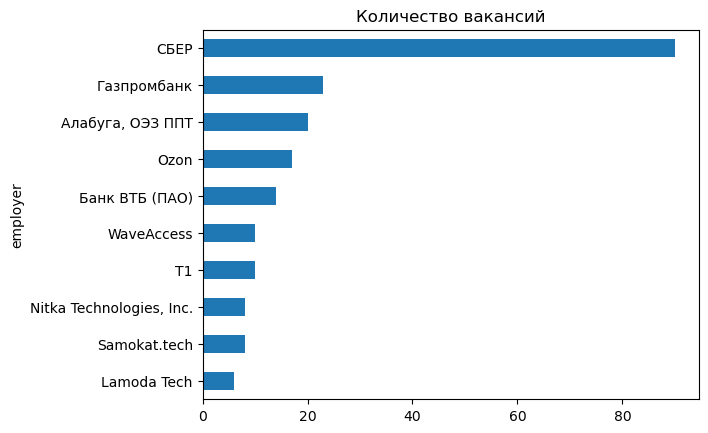

In [16]:
jobs_df.employer.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

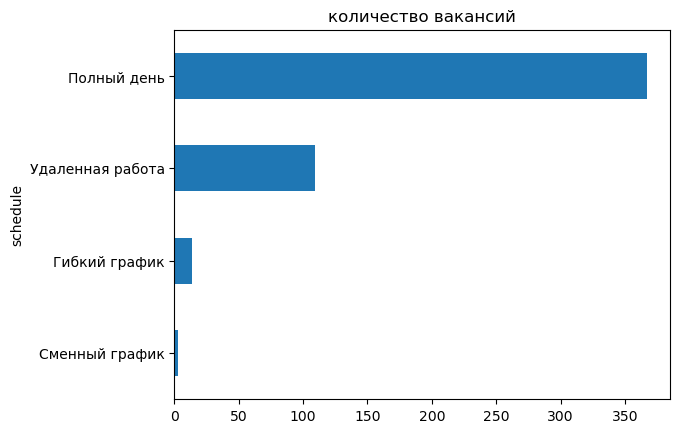

In [17]:
jobs_df.schedule.value_counts().sort_values().plot.barh(title='количество вакансий')
plt.show()

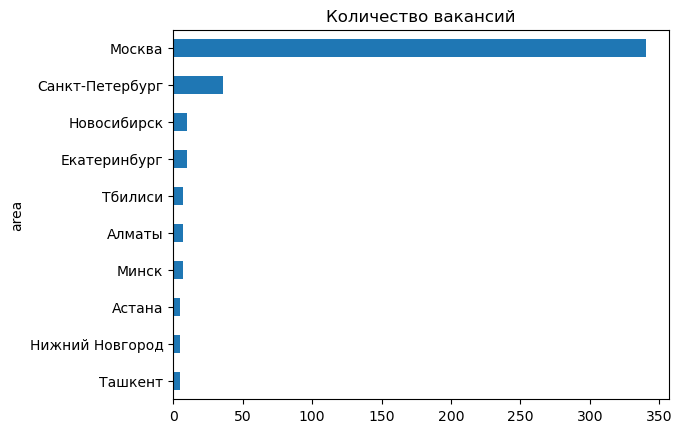

In [18]:
jobs_df.area.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

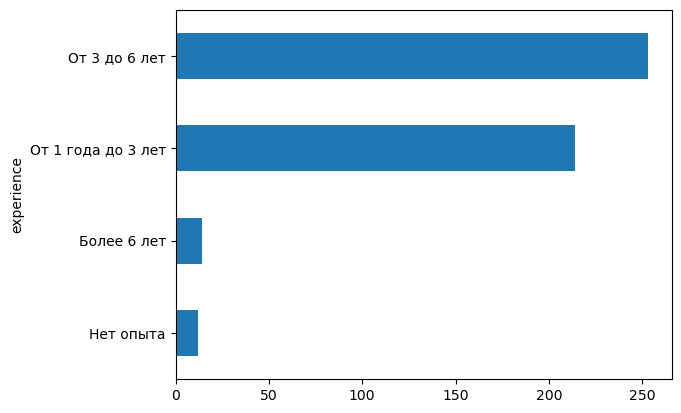

In [19]:
jobs_df.experience.value_counts().sort_values().plot.barh('количество вакансий')
plt.show()

In [20]:
print('Количество вакансий с указанной зарплатой', (~jobs_df.salary.isna()).sum())
print('Доля вакансий с указанной зарплатой', format((~jobs_df.salary.isna()).mean(), '.2f'))

Количество вакансий с указанной зарплатой 64
Доля вакансий с указанной зарплатой 0.13


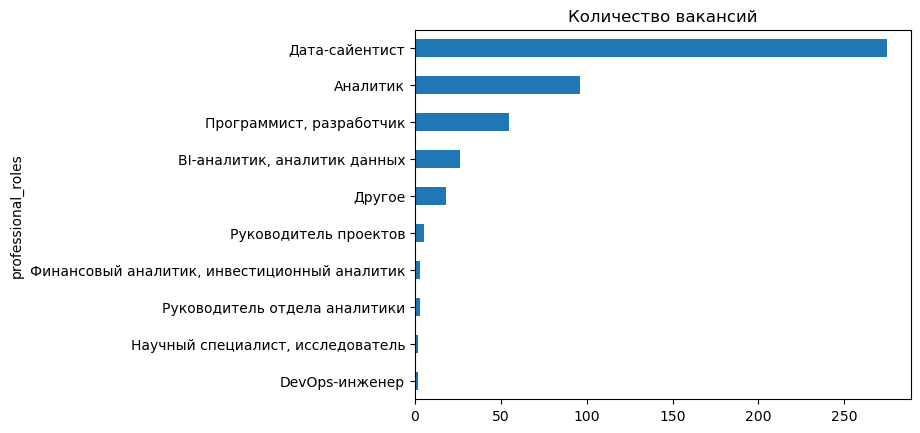

In [21]:
jobs_df.professional_roles.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

In [22]:
jobs_df.professional_roles.unique()

array(['Дата-сайентист', 'Другое', 'Программист, разработчик',
       'Руководитель отдела аналитики', 'Продуктовый аналитик',
       'Аналитик', 'Системный аналитик', 'BI-аналитик, аналитик данных',
       'Специалист технической поддержки',
       'Специалист по информационной безопасности',
       'Руководитель группы разработки', 'Руководитель проектов',
       'DevOps-инженер', 'Менеджер продукта',
       'Финансовый аналитик, инвестиционный аналитик',
       'Системный инженер', 'Научный специалист, исследователь',
       'Учитель, преподаватель, педагог'], dtype=object)

In [28]:
jobs_df[jobs_df.professional_roles == 'DevOps-инженер']

,premium,name,department,has_test,response_letter_required,area,salary,address,published_at,created_at,...,snippet,schedule,working_time_intervals,accept_temporary,professional_roles,experience,employment,key_skills,immediate_redirect_url,immediate_redirect_vacancy_id
id,,,,,,,,,,,,,,,,,,,,,
102097399,False,MLOps Engineer,None,False,False,Москва,None,None,2024-06-17T13:09:50+0300,2024-06-17T13:09:50+0300,...,{'requirement': 'Опыт работы на позициях DataO...,Полный день,None,False,DevOps-инженер,От 3 до 6 лет,Полная занятость,[],NaN,NaN
87302729,False,DevOps инженер (Data Science модели) в Банк,None,False,False,Москва,"{'from': 200000, 'to': None, 'currency': 'RUR'...","{'city': None, 'street': None, 'building': Non...",2024-06-20T14:31:07+0300,2024-06-20T14:31:07+0300,...,{'requirement': 'Будет плюсом: Опыт взаимодейс...,Полный день,None,False,DevOps-инженер,От 1 года до 3 лет,Полная занятость,[],NaN,NaN


In [29]:
jobs_df['salary_aprox'] = jobs_df['salary']\
.apply(lambda el: None if el is None else
       el['to'] / rates[el['currency']] if el['from'] is None
       else el['from'] / rates[el['currency']] if el['to'] is None
       else (el['from'] + el['to']) / 2 / rates[el['currency']])

In [30]:
jobs_df['salary_aprox'].describe()

count        64.00
mean    279_067.69
std     130_273.24
min      25_000.00
25%     200_000.00
50%     300_000.00
75%     303_125.00
max     932_835.82
Name: salary_aprox, dtype: float64

In [31]:
flatten_series(jobs_df.name.str.lower().str.split())\
.apply(lambda el: ''.join(char for char in el if char.isalnum()))\
.value_counts().head(20)

data            468
scientist       413
senior           86
middle           53
в                51
nlp              50
                 50
engineer         43
команду          27
lead             23
и                22
данных           22
аналитик         19
middlesenior     17
junior           16
ml               16
llm              14
рисков           12
analyst          11
learning         11
Name: count, dtype: int64

In [32]:
jobs_df['grade'] = jobs_df['name']\
.apply(lambda el: 'lead' if 'lead' in el.lower()
else 'middle_plus' if ('middle' in el.lower() and 'senior' in el.lower()) or 'middle+' in el.lower()
else 'senior' if 'senior' in el.lower()
else 'middle' if 'middle' in el.lower()
else 'junior' if 'junior' in el.lower()
else 'intern' if 'intern' in el.lower() or 'стажёр' in el.lower() or 'стажер' in el.lower()
else None)

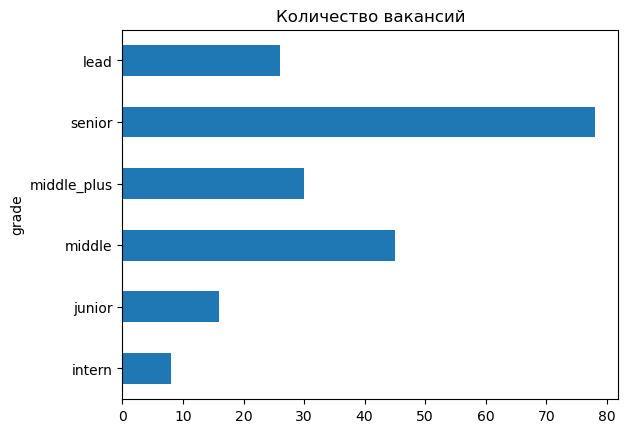

In [33]:
jobs_df.grade.value_counts()\
.loc[['intern',
      'junior',
      'middle',
      'middle_plus',
      'senior',
      'lead']].plot.barh(title='Количество вакансий')
plt.show()

In [36]:
jobs_df_f = jobs_df[~jobs_df['salary_aprox'].isna()]

In [37]:
X = jobs_df_f.drop(['salary', 'address', 'published_at', 'created_at', 'snippet', 'key_skills', 'salary_aprox'], axis=1)
y = jobs_df_f['salary_aprox']

In [38]:
model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True, iterations=20, depth=8)

In [39]:
y_pred = cross_val_predict(model, X.fillna('-'), y, cv=4)

In [40]:
print('mae', mae(y, y_pred))
print('mape', mape(y, y_pred))

mae 85018.01838321099
mape 0.5712601212323762


In [41]:
model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True, iterations=20, depth=8)
model.fit(X.fillna('-'), y)

In [42]:
pd.DataFrame({'feature': model.feature_names_, 'importance': model.feature_importances_})\
.sort_values(by='importance', ascending=False)

,feature,importance
15,grade,26.74
10,professional_roles,24.99
7,schedule,16.92
5,area,16.38
11,experience,7.42
12,employment,4.45
2,department,1.93
9,accept_temporary,0.62
4,response_letter_required,0.32
8,working_time_intervals,0.22


In [43]:
X.drop(['premium', 'name', 'has_test', 'response_letter_required', 'area', 'employer'], axis=1, inplace=True)

In [44]:
model = cb.CatBoostRegressor(cat_features=pd.get_dummies(X).columns.tolist(), silent=True)
y_pred = cross_val_predict(model, pd.get_dummies(X), y, cv=4)
print('mae', mae(y, y_pred))
print('mape', mape(y, y_pred))

mae 99770.11293470432
mape 0.6676581701359576


In [45]:
model = cb.CatBoostRegressor(cat_features=pd.get_dummies(X).columns.tolist(), silent=True)
model.fit(pd.get_dummies(X), y)
imps = pd.DataFrame({'feature': model.feature_names_, 'importance': model.feature_importances_})\
.sort_values(by='importance', ascending=False)
imps.importance /= imps.importance.sum()
imps

,feature,importance
18,experience_От 3 до 6 лет,0.20
11,professional_roles_Аналитик,0.11
6,schedule_Полный день,0.09
17,experience_От 1 года до 3 лет,0.09
5,schedule_Гибкий график,0.08
12,professional_roles_Дата-сайентист,0.07
0,accept_temporary,0.03
9,"professional_roles_BI-аналитик, аналитик данных",0.03
7,schedule_Удаленная работа,0.03
2,department_Алабуга. Human Resources,0.03


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


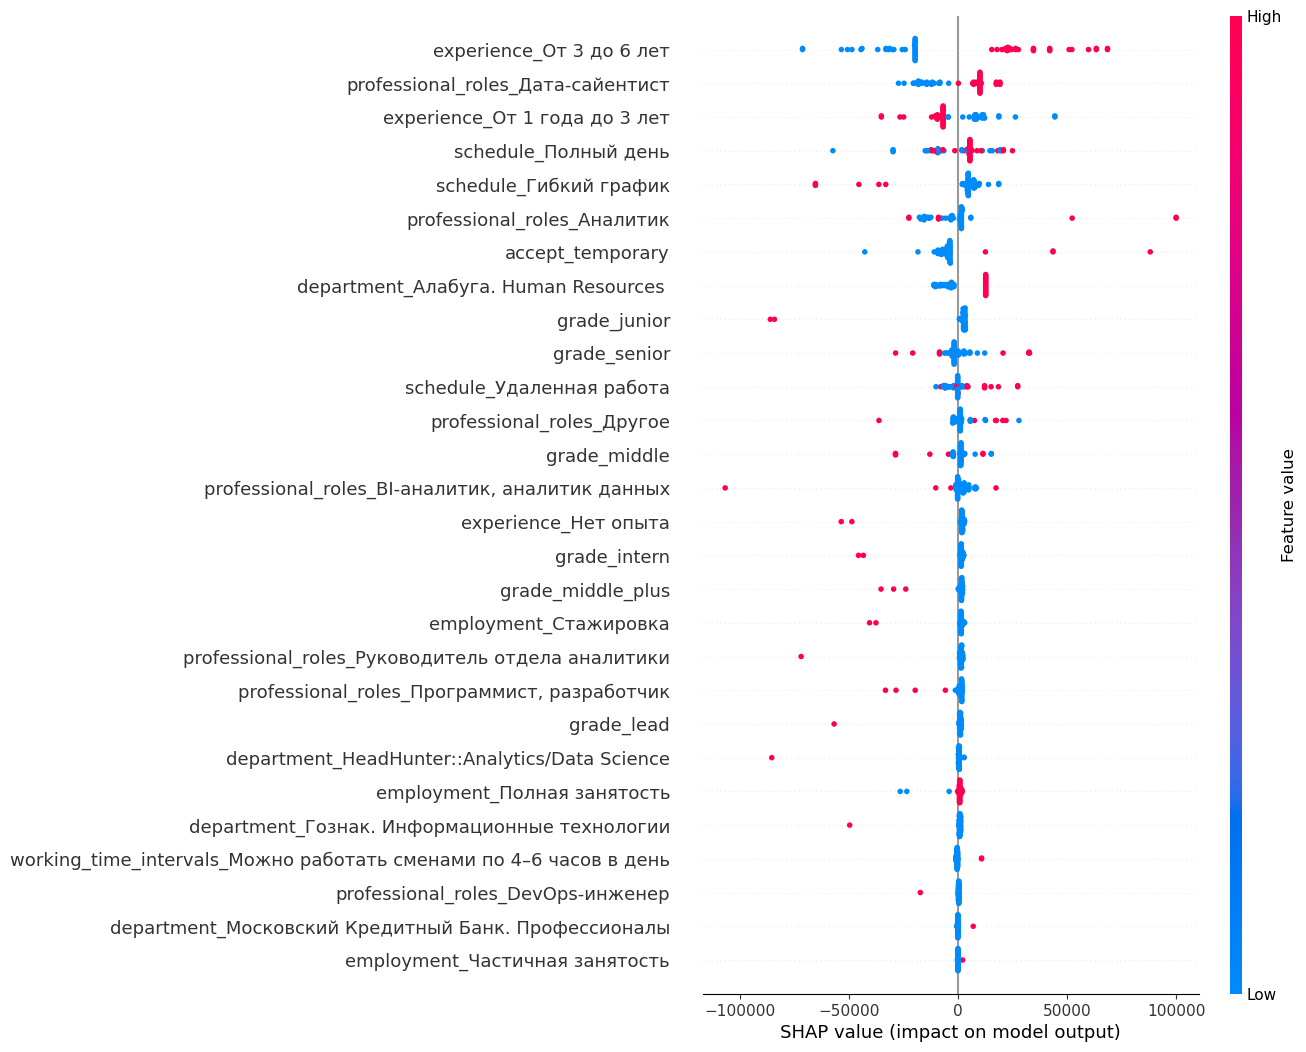

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(pd.get_dummies(X))
shap.plots.beeswarm(shap_values=shap_values, max_display=30)
plt.show()

In [47]:
jobs_dummies = pd.get_dummies(jobs_df[X.columns])
jobs_dummies_f = pd.get_dummies(X)

compare = pd.merge(jobs_dummies.mean().rename('all'), jobs_dummies_f.mean().rename('salary_specified'),
         how='inner',
         left_index=True,
         right_index=True)

In [48]:
compare['diff'] = (compare['all'] - compare['salary_specified']).abs()

In [49]:
compare.sort_values(by='diff', ascending=False)

,all,salary_specified,diff
department_Алабуга. Human Resources,0.04,0.31,0.27
experience_От 1 года до 3 лет,0.43,0.55,0.11
experience_От 3 до 6 лет,0.51,0.42,0.09
schedule_Полный день,0.74,0.66,0.09
professional_roles_Другое,0.04,0.11,0.07
schedule_Гибкий график,0.03,0.09,0.07
professional_roles_Аналитик,0.19,0.14,0.05
"professional_roles_Программист, разработчик",0.11,0.06,0.05
accept_temporary,0.02,0.06,0.04
grade_lead,0.05,0.02,0.04


In [50]:
jobs_df['predict_salary'] = model.predict(jobs_dummies[jobs_dummies_f.columns])

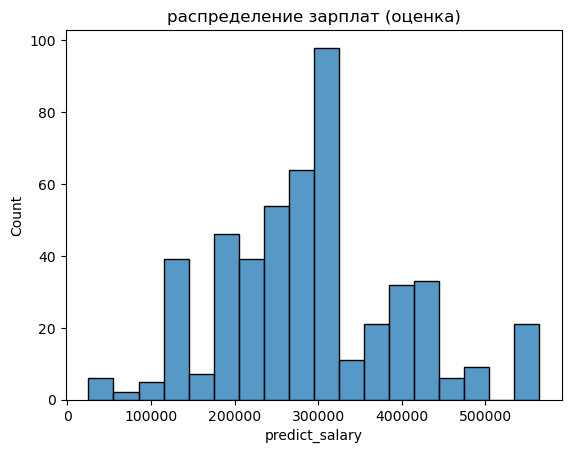

In [51]:
sns.histplot(jobs_df['predict_salary'])\
.set(title='распределение зарплат (оценка)')
plt.show()

In [52]:
jobs_df['predict_salary'].describe()

count       493.00
mean    289_053.50
std     107_206.03
min      25_218.87
25%     224_641.27
50%     272_580.05
75%     344_237.91
max     564_812.00
Name: predict_salary, dtype: float64

In [53]:
print('моя зарплата в Альфа банке')
model.predict(pd.DataFrame({'accept_temporary': [False],
                        'department_HeadHunter::Analytics/Data Science': [False],
                        'department_Гознак. Информационные технологии': [False],
                        'department_Сбер. IT': [False],
                        'schedule_Гибкий график': [False],
                        'schedule_Полный день': [True],
                        'schedule_Удаленная работа': [True],
                        'working_time_intervals_Можно работать сменами по\xa04–6 часов в\xa0день': [False],
                        'professional_roles_BI-аналитик, аналитик данных': [False],
                        'professional_roles_Аналитик': [False],
                        'professional_roles_Дата-сайентист': [True],
                        'professional_roles_Другое': [False],
                        'professional_roles_Программист, разработчик': [False],
                        'experience_Более 6 лет': [False],
                        'experience_Нет опыта': [True],
                        'experience_От 1 года до 3 лет': [False],
                        'experience_От 3 до 6 лет': [False],
                        'employment_Полная занятость': [False],
                        'employment_Проектная работа': [False],
                        'employment_Стажировка': [True],
                        'grade_intern': [True],
                        'grade_junior': [False],
                        'grade_lead': [False],
                        'grade_middle': [False],
                        'grade_middle_plus': [False],
                        'grade_senior': [False]}))[0]

моя зарплата в Альфа банке


CatBoostError: Invalid cat_features[26] = 26 value: index must be < 26.